In [519]:
'''

'''
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image        #convert Images to tensor
from torch.utils.data import Dataset, DataLoader
import cv2
#import torchvision.transforms as T
from PIL import Image
from torchvision import transforms

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [520]:
def get_hyperparameters():
    
    batch_size = 128
    learning_rate = 1e-3
    n_epochs = 5
    log_interval = 10
    momentum = 0.5
    
    return batch_size, learning_rate, n_epochs, log_interval, momentum

In [521]:
def check_processor():
    
    if torch.cuda.is_available():
        device = 'cuda'
        print('Using cuda')
    else:
        device = 'cpu'
        print('Using cpu')
        
    return device

In [522]:
def split_train_test_dataset(training_csv):
       
    train_paths, val_paths, train_labels, val_labels = train_test_split(training_csv["image_id"], training_csv["label"], test_size=0.2, random_state=42)
    
    return train_paths, val_paths, train_labels, val_labels

In [523]:
class PaddyDataset(Dataset):
    
    def __init__(self, dataframe, label2id, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.label2id = label2id
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(self.label2id[labelKey]))  
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)
        
        return image,label, img_name

In [524]:
def get_label2id(training_csv):
    
    labelArr = training_csv['label'].unique()
    label2id = {}
    id2label = {}
    index = 0
    
    for  class_name in labelArr:
        label2id[class_name] = str(index)
        id2label[str(index)] = class_name
        index=index +1
  
    return label2id, id2label

In [525]:
def EDA(paddy_dataset, images, labels, training_csv):
    
    print("EDA:", "\n")
          
    print("Training Dataset size:", len(paddy_dataset), "\n")
    print("Label Distribution:\n", paddy_dataset['label'].value_counts(), "\n")
    
    print("Image size (channel, height, width):", images[0].shape, "\n")
    #print("Visualization of batch #1:")
    #print("-------------------------\n")
    print("True Labels:\n", labels, len(labels), "\n")

In [526]:
def plot(images, labels, id2label, img_name):
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(labels[i]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
        print(img_name[i])
        
    plt.show()

In [527]:
def train_model(n_epochs, model, train_loader, optimizer, log_interval, device):
    
    model.train()
    
    start_time = time.time()
    train_losses = []
    train_counter = []
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target, _) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                           
        output = model(data)
        loss = criterion(output, target)
        #loss = F.nll_loss(output, target)               
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(n_epochs, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((n_epochs-1)*len(train_loader.dataset)))
            '''
            torch.save(model.state_dict(), './model.pth') 
            torch.save(optimizer.state_dict(), './optimizer.pth')
            '''
    total_time = time.time() - start_time
    print("Total running time:", total_time)

In [528]:
def val_model(model, val_loader, device):
    model.eval()
    
    test_loss = 0
    correct = 0
    model_output = []
    test_losses = []
    files = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():                   #no_grad means no gradient magnitude
        for data, target, file_name in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            model_output.append(output)
            files.append(file_name)
            
    test_loss /= len(val_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

    return model_output[0], files, accuracy.item()

Training Dataset size: 9886 Validation Dataset Size: 521 

id2label {'0': 'bacterial_leaf_blight', '1': 'bacterial_leaf_streak', '2': 'bacterial_panicle_blight', '3': 'blast', '4': 'brown_spot', '5': 'dead_heart', '6': 'downy_mildew', '7': 'hispa', '8': 'normal', '9': 'tungro'} 

label2id {'bacterial_leaf_blight': '0', 'bacterial_leaf_streak': '1', 'bacterial_panicle_blight': '2', 'blast': '3', 'brown_spot': '4', 'dead_heart': '5', 'downy_mildew': '6', 'hispa': '7', 'normal': '8', 'tungro': '9'} 

Images of first training batch
../input/paddy-doctor/train_images/normal/100664.jpg
../input/paddy-doctor/train_images/normal/109781.jpg
../input/paddy-doctor/train_images/dead_heart/101724.jpg
../input/paddy-doctor/train_images/hispa/106414.jpg
../input/paddy-doctor/train_images/bacterial_leaf_streak/108603.jpg


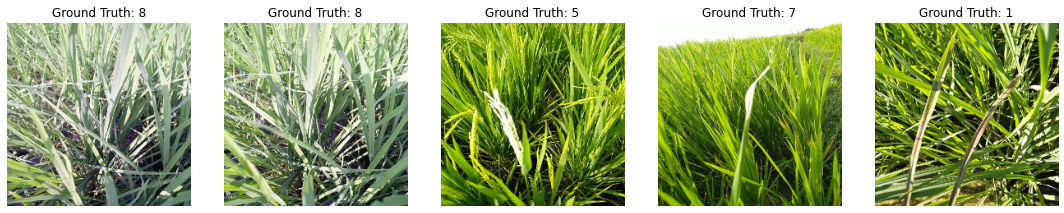

EDA: 

Training Dataset size: 9886 

Label Distribution:
 normal                      1683
blast                       1651
hispa                       1498
dead_heart                  1370
tungro                      1036
brown_spot                   913
downy_mildew                 586
bacterial_leaf_blight        463
bacterial_leaf_streak        363
bacterial_panicle_blight     323
Name: label, dtype: int64 

Image size (channel, height, width): torch.Size([3, 224, 224]) 

True Labels:
 tensor([8, 8, 5, 7, 1, 9, 2, 4, 5, 9, 3, 1, 2, 5, 5, 8, 2, 9, 3, 9, 5, 9, 8, 6,
        5, 5, 9, 3, 4, 7, 2, 7, 7, 8, 7, 8, 3, 9, 3, 5, 8, 5, 9, 3, 1, 9, 8, 4,
        2, 5, 9, 3, 0, 2, 4, 9, 5, 0, 7, 9, 7, 5, 0, 8, 6, 3, 3, 5, 8, 4, 8, 4,
        8, 4, 8, 0, 2, 8, 7, 9, 0, 8, 7, 6, 7, 7, 5, 0, 0, 8, 5, 6, 2, 3, 3, 9,
        1, 3, 4, 5, 5, 3, 6, 4, 6, 8, 8, 8, 3, 4, 3, 0, 5, 3, 8, 5, 2, 1, 4, 4,
        9, 3, 4, 9, 4, 0, 1, 3]) 128 

Using cpu

Test set: Avg. loss: 0.0041, Accuracy: 469/521 (90%)

a

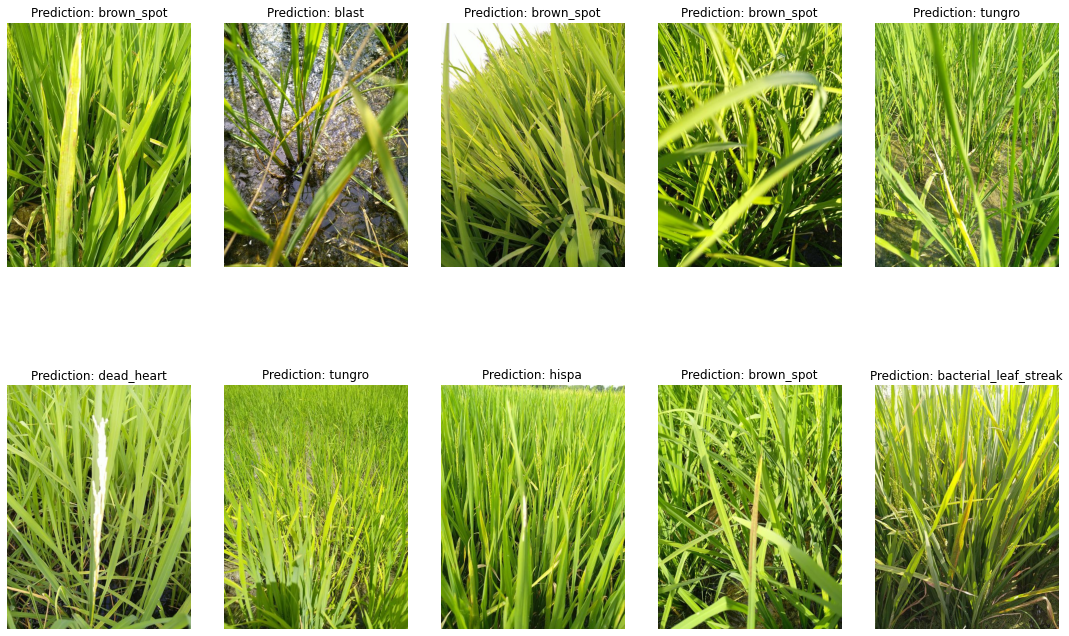

In [529]:
def main(argv):

    # -------- Prepare dataset
    torch.manual_seed(42)  
    torch.backends.cudnn.enabled = False
    
    batch_size, learning_rate, n_epochs, log_interval, momentum  = get_hyperparameters()

    training_csv = pd.read_csv("../input/paddy-doctor/train.csv")
    train, valid = train_test_split(training_csv, test_size=0.05,random_state=0)
    print("Training Dataset size:", len(train), "Validation Dataset Size:", len(valid), "\n")
    
    label2id, id2label = get_label2id(training_csv)
    print("id2label", id2label, "\n")
    print("label2id", label2id, "\n")

    transform_dataset = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
    
    train_dataset = PaddyDataset(train, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    valid_dataset = PaddyDataset(valid, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers=2)
    
    images, labels, img_name = next(iter(train_dataloader))
    print("Images of first training batch")
    plot(images, labels, id2label, img_name)
    
    EDA(train, images, labels, training_csv)

    device = check_processor()
    
    # --------- Define model
    resnet34 = models.resnet34(pretrained=True)
    
    resnet34.fc =  nn.Sequential(nn.Dropout(0.1),
                               nn.Linear(512, 10))
    
    resnet34 = resnet34.to(device)

    optimizer = optim.SGD(resnet34.parameters(), lr=learning_rate, momentum=momentum)
    
    # ---------- load previous training weights
    
    network_state_dict = torch.load('../input/paddy-disease-detection/model.pth', map_location = device)
    resnet34.load_state_dict(network_state_dict)
    
    optimizer_state_dict = torch.load('../input/paddy-disease-detection/optimizer.pth', map_location = device)
    optimizer.load_state_dict(optimizer_state_dict)
    
    n_epochs = 1
    
    # ------- Train model
    
    accuracy_resnet34 = []
    
    for epoch in range(1, n_epochs + 1): 
        #train_model(epoch, resnet34, train_dataloader, optimizer, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
        accuracy_resnet34.append(accuracy)
        
    print("accuracy_resnet34", accuracy_resnet34)
        
    # ------- Visualize prediction
    test_samples = enumerate(val_dataloader)
    batch_idx, (test_images, test_targets, _) = next(test_samples)
    print("test_targets")
    print(test_targets)
    print("test_images shape", test_images.shape)
    
    pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
    
    transform = T.ToPILImage()
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(10):
        plt.subplot(3, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        
        prediction = np.argmax(pred[i].cpu()).item()
        plt.title("Prediction: {}".format(id2label[str(prediction)]))
        
        plt.imshow(cv2.cvtColor(cv2.imread(filenames[0][i]), cv2.COLOR_BGR2RGB))
      
        print(filenames[0][i])
        
    plt.show()
                  
    return

if __name__ == "__main__":
    main(sys.argv)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session